# Keyrir Strætó of hratt?: Samanburður keyrsluhraðagagna frá Strætó API-inu við hámarkshraðagögn

_**Árni Dagur Guðmundsson**: arni@dagur.eu | Menntaskólinn við Hamrahlíð_

# Inngangur:

## Markmið

Ég bý í Ásahverfinu í Garðabænum, og þarf því oft að taka Strætó 23 á milli húsa foreldra minna, sem hafa skilið. Við þá upplifun er þó ekki hægt að komast hjá því að taka eftir líkindum strætóleiðarinnar við rússíbana – skemmtitækið sem hafði því miður alveg vantað á Íslandi fyrr en Strætó byrjaði að keyra í gegn um hverfið. Sú var ekki eina uppgvötunin sem ég gerði á þessum tíma, en ég komst einnig að því að API Strætóappsins er hægt að nálgast (meira um það fyrir neðan). Augljós samblanda er því að nota API-ið til sýna fram á tölulega hversu hratt þessi strætóleið ekur.

## Tækni

Hér verður farið yfir í stuttu máli þá tækni sem notuð er.

### Open Street Map

Flestir þekkja eflaust Open Street Map, en eins og nafnið gefur til kynna er það götukort sem gefið út er með frjálsu höfundarréttaleyfi. Notkun mín á OSM í þessu verkefni má skipta í tvo hluta.

1. Notkun vektorupplýsinga gatnanna til að búa til falleg kortarit líkt og það sem má sjá hér fyrir neðan.
2. Notkun hámarkshraðagagna gatna sem finna má í upplýsingum hvers götuvektors.

Það vill svo heppilega til að þýska fyrirtækið _Geofabrik_ bíður upp á ókeypis niðurhal OSM gagna einstakra heimshluta, þar á meðal Ísland. Sjá: <https://download.geofabrik.de/europe/iceland.html>

Ég bjó til einfalt fall sem niðurhalar þessum gögnum sjálfkrafa, og kallar í bash forrit sem breytir gögnunum í það form sem við viljum vinna með, og spýtir út í möppuna `osm-data/`.

In [27]:
from straeto.data import get_osm_data
get_osm_data(verbose=True)

gis_osm_roads_free_1.cpg extracted to osm-data/
gis_osm_roads_free_1.dbf extracted to osm-data/
gis_osm_roads_free_1.prj extracted to osm-data/
gis_osm_roads_free_1.shp extracted to osm-data/
gis_osm_roads_free_1.shx extracted to osm-data/
Running extract_roads bash script...


KeyboardInterrupt: 

Hér má sjá innihald `osm-data/`. Takið eftir að notast er við forskeytið `!` til að keyra bash skipun í stað Python kóða.

In [31]:
!printf 'osm-data/:\n' \
&& ls osm-data/ \
&& printf '\nosm-data/output/:\n' \
&& ls osm-data/output

osm-data/:
gis_osm_roads_free_1.cpg  gis_osm_roads_free_1.prj  gis_osm_roads_free_1.shx
gis_osm_roads_free_1.dbf  gis_osm_roads_free_1.shp  output

osm-data/output/:
extracted_roads.cpg  extracted_roads.shx     no_extracted_roads.shp
extracted_roads.dbf  no_extracted_roads.cpg  no_extracted_roads.shx
extracted_roads.prj  no_extracted_roads.dbf
extracted_roads.shp  no_extracted_roads.prj


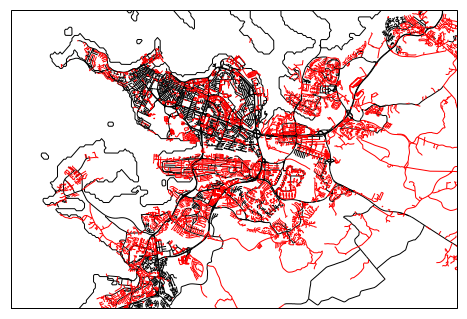

In [4]:
fig, ax = straeto.get_map(region='reykjavik', res='f')

ax = straeto.add_shapefile(ax, 'osm-data/output/extracted_roads.shp')
ax = straeto.add_shapefile(ax, 'osm-data/output/no_extracted_roads.shp', edgecolor='red')

plt.show()

### API
Falið í kóða heimasíðu Strætó má finna API (forritaskil) sem geyma ýmsar upplýsingar um staka strætisvagna í rauntíma. Strætó appið notar þetta API meðal annars til að sýna staðsetningu strætisvagna á korti. Ég bjó til einfaldan Python pakka sem kallar á API-ið og spýtir út niðurstöðunum í JSON. Hér fyrir neðan sést niðurstaða einfalds kalls:

In [5]:
from straeto import api
api.getBusPositionsFor(["1", "55"])[0]

{'deviceNumber': 123,
 'route': '1-B',
 'gpsTime': '180723194024',
 'lat': 64.0910516666667,
 'lon': -21.9280666666667,
 'speed': 13.49,
 'heading': 225.43,
 'gpsFix': 1,
 'routeNumber': '1',
 'lastStop': 13001523,
 'nextStop': 13001589,
 'pingCode': 6}

Eins og sést býður API-ið upp á breiddargráðu (_lat_), og lengdargráðu (_lon_). Því er til dæmis hægt að birta staðsetningu allra strætisvagna landsins á kort líkt og svo:

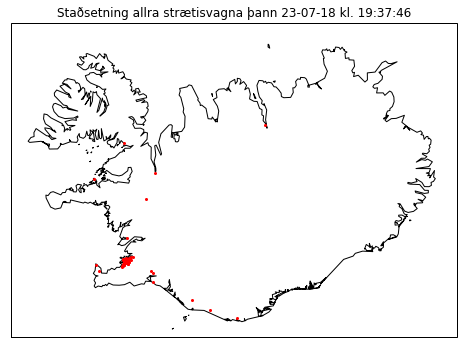

In [6]:
from datetime import datetime

fig, ax = straeto.get_map(region='iceland')

for bus in api.getAllBusPositions():
    plt.plot(bus['lon'], bus['lat'], marker='o', color='red', markersize=2,
             transform=ccrs.Geodetic())

plt.title('Staðsetning allra strætisvagna þann {}'.format(datetime.now().strftime('%d-%m-%y kl. %H:%M:%S')))
plt.show()

Hraðinn er einnig til staðar en ekki vitum við þó hvaða mælieining notuð er til þess að mæla hann.

$k\cdot v_{api} = v \Rightarrow k = \frac{v}{v_{api}}$

In [7]:
from straeto import straeto
bdict, p_bdict = straeto.getConsecutiveBuses(ratio=0.5)

print(len(bdict),len(p_bdict))

49 49


In [8]:
from geopy.distance import geodesic
from datetime import datetime as dt
G = []
B = []
Ks = []
for key in bdict:
    bus = bdict[key]; p_bus = p_bdict[key]
    t_1 = dt.strptime(bus['gpsTime'],"%y%m%d%H%M%S"); t_2 = dt.strptime(p_bus['gpsTime'],"%y%m%d%H%M%S")
    delta_t = (t_1-t_2).total_seconds()
    delta_s = geodesic((bus['lat'], bus['lon']), (p_bus['lat'], p_bus['lon'])).km

    kmh = (delta_s/delta_t)*3600
    avg_speed = (1/2)*(bus['speed']+p_bus['speed'])

    k = kmh/avg_speed
    Ks.append(k)
    dic = {
        'speed_0': p_bus['speed'],
        'speed_1': bus['speed'],
        'delta_s': delta_s,
        'delta_t': delta_t,
        'kmh': kmh,
        'avg_speed': avg_speed,
        'route': bus['route'],
        'k': k
    }
    if 1.7 < k < 1.9:
        G.append(dic)
    else:
        B.append(dic)

print('Good:')
for i in G:
    print('{} | k = {} / {} = {} | {} --> {}'.format(
        i['route'], round(i['kmh'], 2), round(i['avg_speed'], 2), round(i['k'], 2), i['speed_0'], i['speed_1']
    ))
print('Bad:')
for i in B:
    print('{} | k = {} / {} = {} | {} --> {}'.format(
        i['route'], round(i['kmh'], 2), round(i['avg_speed'], 2), round(i['k'], 2), i['speed_0'], i['speed_1']
    ))
avg_k = sum(Ks)/len(Ks)
print(avg_k)


Good:
4-B | k = 7.58 / 4.13 = 1.83 | 5.87 --> 2.4
51-A | k = 88.75 / 48.61 = 1.83 | 48.21 --> 49.0
2-B | k = 21.38 / 12.57 = 1.7 | 23.0 --> 2.14
17-B | k = 38.73 / 20.64 = 1.88 | 20.45 --> 20.83
51-C | k = 98.41 / 52.92 = 1.86 | 52.95 --> 52.9
58-A | k = 43.58 / 24.45 = 1.78 | 24.45 --> 24.44
A6 | k = 47.29 / 25.21 = 1.88 | 26.2 --> 24.22
6-C | k = 20.28 / 11.57 = 1.75 | 12.75 --> 10.4
89-A | k = 86.68 / 46.47 = 1.87 | 47.16 --> 45.77
14-B | k = 52.43 / 28.0 = 1.87 | 27.05 --> 28.95
15-A | k = 36.96 / 19.84 = 1.86 | 19.23 --> 20.45
59-A | k = 68.44 / 37.06 = 1.85 | 33.77 --> 40.34
52-A | k = 42.53 / 22.65 = 1.88 | 19.37 --> 25.92
57-C | k = 94.86 / 51.3 = 1.85 | 51.32 --> 51.28
55-A | k = 64.48 / 34.88 = 1.85 | 36.15 --> 33.62
57-D | k = 83.57 / 44.84 = 1.86 | 44.66 --> 45.02
6-B | k = 34.59 / 18.45 = 1.87 | 25.86 --> 11.04
18-B | k = 16.9 / 9.79 = 1.73 | 17.39 --> 2.19
Bad:
43-C | k = 35.29 / 16.3 = 2.16 | 21.55 --> 11.06
11-C | k = 22.69 / 13.54 = 1.68 | 9.37 --> 17.72
43-D | k = 30.

## Undirbúningur gagna:
Load sqlite files:
```
pgloader 25-03-2018.db postgresql:///straeto
```
Started 22:37
```
UPDATE buses b SET maxspeed = (SELECT r.maxspeed FROM roads r ORDER BY b.geom <-> r.geom LIMIT 1);
```
Aðeins hraðara: (37-39 sec með index)
```
UPDATE buses b SET maxspeed = (SELECT r.maxspeed FROM roads r WHERE ST_Expand(b.geom, 0.012) && r.geom ORDER BY b.geom <-> r.geom LIMIT 1);
```

In [9]:
%alias sql psql straeto -c

In [10]:
sql "\dt"

            List of relations
 Schema |      Name       | Type  | Owner 
--------+-----------------+-------+-------
 public | buses           | table | arni
 public | roads           | table | arni
 public | spatial_ref_sys | table | arni
(3 rows)



In [11]:
#sql "ALTER TABLE buses ADD COLUMN geom Geometry(Point, 4326);"

In [12]:
#sql "UPDATE buses SET geom=ST_SetSrid(ST_MakePoint(lon, lat), 4326);"

In [13]:
#sql "CREATE INDEX buses_gix ON buses USING gist(geom);"

In [14]:
#sql "VACUUM ANALYZE;"

In [15]:
#sql "ALTER TABLE buses ADD maxspeed integer;"

## Úrvinnsla gagna:

In [16]:
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as pd_sql

connection = pg.connect(database='straeto',
                        # Location of .s.PGSQL.5432 file;
                        # try host='/tmp' if you get an error.
                        host='/var/run/postgresql')
df = pd_sql.read_sql("SELECT gps_time, route_number, lat, lon, speed, maxspeed FROM buses;", connection)

In [17]:
df['gps_time'] = pd.to_datetime(df['gps_time'], format='%y%m%d%H%M%S')
df['speed'] = df['speed']*1.85

In [18]:
df = df.set_index('gps_time')

In [19]:
df.head(3)

,route_number,lat,lon,speed,maxspeed
gps_time,,,,,
2018-03-24 23:58:05,12,64.1280,-21.9471,0.0000,0
2018-03-24 23:58:07,3,64.1330,-21.8965,50.9675,60
2018-03-24 23:58:06,7,64.1689,-21.6923,19.9615,30


In [20]:
df = df.query('maxspeed > 0')
df['ratio'] = df['speed']/df['maxspeed']

In [21]:
over = df.query('maxspeed < speed')
under = df.query('maxspeed >= speed')

In [22]:
df.head(8)

,route_number,lat,lon,speed,maxspeed,ratio
gps_time,,,,,,
2018-03-24 23:58:07,3,64.1330,-21.8965,50.9675,60,0.849458
2018-03-24 23:58:06,7,64.1689,-21.6923,19.9615,30,0.665383
2018-03-24 23:58:05,15,64.1455,-21.9677,28.3235,30,0.944117
2018-03-24 23:58:05,12,64.1243,-21.8482,61.3645,60,1.022742
2018-03-24 23:58:05,15,64.1628,-21.7282,27.5465,50,0.550930
2018-03-24 23:58:05,3,64.1455,-21.9245,22.2555,30,0.741850
2018-03-24 23:58:08,18,64.1287,-21.7731,68.9495,80,0.861869
2018-03-24 23:58:07,28,64.1101,-21.8880,24.6790,50,0.493580


In [23]:
print(len(over), len(under), round(len(over)*100/len(under), 1))

64434 331371 19.4


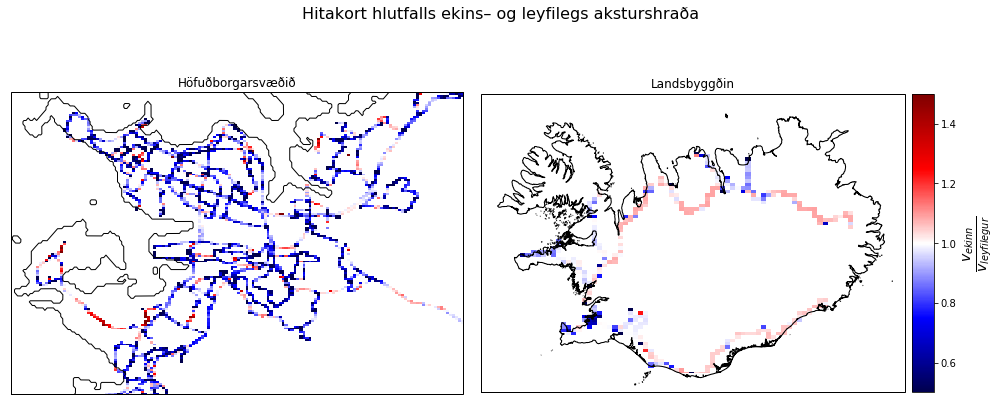

In [24]:
%matplotlib inline
import numpy as np

x = df['lon']
y = df['lat']
ratios = df['ratio']

fig, (ax, ax2) = straeto.get_map(region=[['reykjavik', 1.15], 'iceland'], res='f',
                                 figsize=(14, 7), shape=(1, 2))
# The heatmap itself
im = straeto.add_heatmap(ax, x, y, ratios, bins=4000, statistic='median')
im = straeto.add_heatmap(ax2, x, y, ratios, bins=65, statistic='median')
# The colourbar
straeto.add_colorbar(fig, ax2, im, label='$\\frac{v_{ekinn}}{v_{leyfilegur}}$')

fig.suptitle('Hitakort hlutfalls ekins– og leyfilegs aksturshraða', size=16)
ax.set_title('Höfuðborgarsvæðið')
ax2.set_title('Landsbyggðin')

fig.tight_layout()
plt.subplots_adjust(top=1)
plt.show()

In [25]:
df_23 = df.query('route_number == "23"')
df_23.head(3)

,route_number,lat,lon,speed,maxspeed,ratio
gps_time,,,,,,
2018-03-25 09:21:39,23,64.0897,-21.9299,0.0000,30,0.000000
2018-03-25 09:21:49,23,64.0897,-21.9299,0.0185,30,0.000617
2018-03-25 09:21:59,23,64.0897,-21.9298,0.0925,30,0.003083


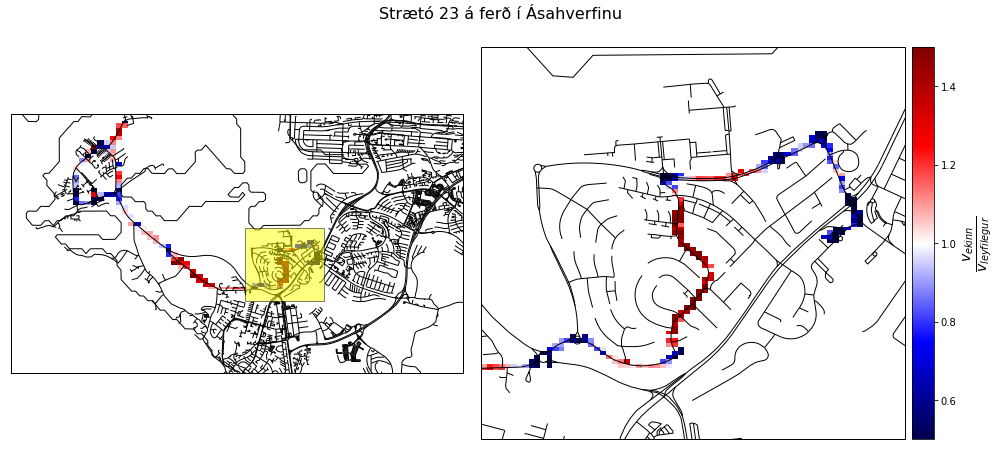

In [26]:
import shapely.geometry as sgeom

box = sgeom.box(minx=-21.957609, maxx=-21.925687, miny=64.082863, maxy=64.095775)
x0, y0, x1, y1 = box.bounds

x = df_23['lon']
y = df_23['lat']
ratios = df_23['ratio']

fig, (ax, ax2) = straeto.get_map(region=[[[-22.043032, -21.878363, 64.072429, 64.113672], 0.9],
                                 [[x0, x1, y0, y1], 0.9]],
                          res='f', figsize=(14, 7), shape=(1, 2))

ax2 = straeto.add_shapefile(ax2, 'osm-data/output/extracted_roads.shp')
ax = straeto.add_shapefile(ax, 'osm-data/output/extracted_roads.shp')
ax2 = straeto.add_shapefile(ax2, 'osm-data/output/no_extracted_roads.shp')
ax = straeto.add_shapefile(ax, 'osm-data/output/no_extracted_roads.shp')

im = straeto.add_heatmap(ax, x, y, ratios, bins=40, statistic='median')
ax.add_geometries([box], ccrs.PlateCarree(), facecolor='yellow', edgecolor='black', alpha=0.5)

im = straeto.add_heatmap(ax2, x, y, ratios, bins=200, statistic='median')
straeto.add_colorbar(fig, ax2, im, label='$\\frac{v_{ekinn}}{v_{leyfilegur}}$')

fig.suptitle('Strætó 23 á ferð í Ásahverfinu', size=16)
fig.tight_layout()
plt.subplots_adjust(top=1)
plt.show()